In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from PIL import Image
import pathlib

In [2]:
# loading data
DATA_DIR = "facial_expressions/data"
IMAGE_DIR = "facial_expressions/images"
data = pd.read_csv(f'{DATA_DIR}/legend.csv')
data['emotion'] = data['emotion'].str.lower()

In [3]:
# prepping training datasets
X = []
# ran into too many files open error: https://stackoverflow.com/questions/29234413/too-many-open-files-error-when-opening-and-loading-images-in-pillow
# find the minimum width and height and I can resize all images to that shape
min_width = 1000
min_height = 1000
for image in data['image']:
    temp = Image.open(IMAGE_DIR + '/' + image)
    keep = temp.copy().convert('L')
    min_width = min(min_width, keep.size[0])
    min_height = min(min_height, keep.size[1])
    X.append(keep)
    temp.close()
Y = np.array(data['emotion'])
classes = np.array(set(Y))
# spliting data in to training and validation sets
split_factor = 0.8
stop = int(split_factor * len(X))
Xtr,Xva = X[:stop],X[stop:]
Ytr,Yva = Y[:stop],Y[stop:]

In [4]:
# Training
# steps from Wikipedia: https://en.wikipedia.org/wiki/Eigenface
# all images should be resampled to a common pixel resolution
Xtr = [np.asarray(image.resize((min_width, min_height))) for image in Xtr]
# each image will be treated as a vector, concatenate all rows in an image to a single column
# store all images in the training set into one matrix, T
T = np.array([image.flatten() for image in Xtr])

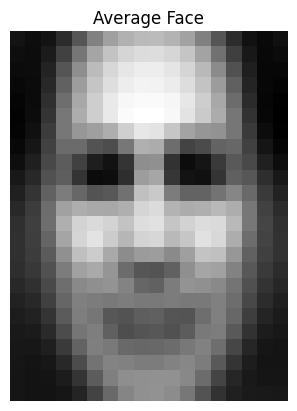

In [5]:
# calculates the mean/average face
average_face = np.mean(T,0)
average_face_image = np.reshape(average_face, (min_height, min_width))
plt.figure()
plt.title('Average Face')
plt.imshow(average_face_image, cmap="gray")
plt.axis('off')
plt.show()
# subtract mean face from each original image in T
T = T - average_face
# obtain the covariance matrix, S
S = np.cov(T.T)
# obtain eigenvectors and eigenvalues from the covariance matrix
eigenvalues,eigenvectors = sp.linalg.eig(S)
# sort the eigenvalues in descending order and arrange eigenvectors accordingly.
# went to stackoverflow for help: https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

In [7]:
# only some eigenfaces are needed for certain variance
variance = 0.95
comp_eigen_sum = 0
eigen_sum = np.sum(eigenvalues)
# k = number of principal components
k = 1
for i, eigenvalue in enumerate(eigenvalues):
    comp_eigen_sum += eigenvalue
    total_variance = comp_eigen_sum/eigen_sum
    if total_variance > 0.95:
        k += i
print(k)

89269
